In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
import seaborn as sns
from statsmodels.stats.anova import AnovaRM

import h5py

from tqdm import tqdm

In [2]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [3]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import stat as sstat

In [4]:
import warnings

---

In [5]:
mpl.rcParams['font.family'] = 'Helvetica'

### Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [6]:
dir_behav = su.get_dir_behav()

---

In [7]:
list_sn = su.get_list_sn()
list_sn

array(['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13',
       '14'], dtype='<U2')

---

## sessions
- ses-1 (S)
- ses-2 (R)

Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (~16 seconds)
4. Each run takes about 7 minutes
5. 17-, 34-, 57-, 64-th trial's ITI are $16000$

## motor sequences
- 32451
- 35124
- 13254
- 14523
## visual cues
- letter
- spatial

---

### (point, isError)
1) (0,0): MT=0 but the response is correct up to that point.
2) (0,1): At some point, the response becomes incorrect.
3) (1,0): A properly conducted trial.

PrepTime(1s) + press(3s) + ITI(1s) = 5s
- $\text{MT} \neq pressTime4 - pressTime0$
- $\text{RT} = pressTime0 - 1000(PrepTime) - (4\text{ or }6)$

## 1. Repetition

 | | symbol | trial$_{t-1}$ | trial $_{t}$ |
 |---------|---------|---------|---------|
 | Both-Rep$_{c}$ <br> (within-$c$ repetition) | <span style="color:#00008B">$B_{c}$</span> | $(s,c)$ | $(s,c)$ |
 | Cue-Rep$_{c}$ <br> (within-$c$ no-repetition) | <span style="color:#0000FF">$C_{c}$</span> | $(\neg s,c)$ | $(s,c)$ |
 | Seq-Rep$_{c}$ <br> (between-$c$ repetition) | <span style="color:#8B0000">$S_{c}$</span> | $(s,\neg c)$ | $(s,c)$ |
 | Non-Rep$_{c}$ <br> (between-$c$ no-repetition) | <span style="color:#FF0000">$N_{c}$</span> | $(\neg s,\neg c)$ | $(s,c)$ |

$Trial State=(s,c)$:\
$ s=0: 32451 $, $ s=1: 35124 $, $s=2: 13254 $, $s=3: 14523$ \
$ c=0: Letter $, $ c=1: Spatial $

In [8]:
dg = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for sess in ['S','R']:
        for sn in tqdm(list_sn):
            subj = sess+sn
            fname = join(dir_behav,'sub-%s/behav_info.tsv'%subj)
            df = pd.read_csv(fname, delimiter='\t')
            df_tmp = df.copy()
    
            df_tmp['ITI-1'] = df.ITI.shift(1)
            df_tmp['cue-1'] = df.cue.shift(1)
            df_tmp['sequence-1'] = df.sequence.shift(1)
            df_tmp['RT-1'] = df.RT.shift(1)
            df_tmp['MT-1'] = df.MT.shift(1)
            
            ## 1 <= TN <= 64
            df = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=64)].copy()
            ## ITI-1 <= 1000 ms
            df = df[df['ITI-1']<=1000]
            # df = df[df['isError']==0]
            ## long term trials have no previous trial
            # df_tmp[df_tmp.TN%17==1]['MT-1']=np.nan
            # df_tmp[df_tmp.TN%17==1]['RT-1']=np.nan
    
            df['ITI-1'] = df['ITI-1'].astype(int)
            # df['cue-1'] = df['cue-1'].astype(int)
            df['sequence-1'] = df['sequence-1'].astype(int)
            df['RT-1'] = df['RT-1'].astype(int)
            df['MT-1'] = df['MT-1'].astype(int)
            
            ## default condition = NRep
            df['cond'] = 'Between No-Rep'
            ## other conditions
            df.loc[(df.cue==df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Within Rep'
            df.loc[(df.cue==df['cue-1'])&(df.sequence!=df['sequence-1']),'cond'] = 'Within No-Rep'
            df.loc[(df.cue!=df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Between Rep'
            ## subj label
            df['sess']=1 if sess=='S' else(2 if sess=='R' else 0)
            df['subj']=sn
            df['x'] = ['%s_%d'%(cue,ses) for cue,ses in zip(df['cue'], df['sess'])]
            ## 수행한 total trial number
            df['trial']=(df.BN-1)*64+df.TN
            ## remove unncessary rows
            df = df[df.TN%17 != 1]

            dg = pd.concat([dg,df])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.98it/s]


In [9]:
dg['cond'] = dg.cond.replace({
    'Both-Rep':'Within Rep', 'Cue-Rep':'Within No-Rep',
    'Seq-Rep':'Between Rep', 'Non-Rep':'Between No-Rep'
})
dg

,BN,TN,onset,prepTime,cue,sequence,MT,RT,isError,ITI,...,ITI-1,cue-1,sequence-1,RT-1,MT-1,cond,sess,subj,x,trial
1,1,2,13030,1000,S,4,1720,382,0,1000,...,1000,S,2,566,1680,Within No-Rep,1,01,S_1,2
2,1,3,18030,1000,L,4,2056,438,0,1000,...,1000,S,4,382,1720,Between Rep,1,01,L_1,3
3,1,4,23030,1000,L,2,1528,478,0,1000,...,1000,L,4,438,2056,Within No-Rep,1,01,L_1,4
4,1,5,28030,1000,S,1,1308,408,0,1000,...,1000,L,2,478,1528,Between No-Rep,1,01,S_1,5
5,1,6,33030,1000,L,2,1776,446,0,1000,...,1000,S,1,408,1308,Between No-Rep,1,01,L_1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,8,60,348020,1000,L,3,1060,322,0,1000,...,1000,S,3,374,1038,Between Rep,2,14,L_2,508
536,8,61,353020,1000,S,2,1042,308,0,1000,...,1000,L,3,322,1060,Between No-Rep,2,14,S_2,509
537,8,62,358020,1000,L,2,1172,312,0,1000,...,1000,S,2,308,1042,Between Rep,2,14,L_2,510
538,8,63,363020,1000,L,4,1010,348,0,1000,...,1000,L,2,312,1172,Within No-Rep,2,14,L_2,511


In [10]:
dg.columns

Index(['BN', 'TN', 'onset', 'prepTime', 'cue', 'sequence', 'MT', 'RT',
       'isError', 'ITI', 'response', 'ITI-1', 'cue-1', 'sequence-1', 'RT-1',
       'MT-1', 'cond', 'sess', 'subj', 'x', 'trial'],
      dtype='object')

---
---

### 학습이 일어났는가?

In [11]:
## invalid trial들은 제거 후 Block마다 within subject 평균
dh = dg[dg.isError==0].groupby(['sess','subj','BN'])[['MT','RT']].median().reset_index()
dh

,sess,subj,BN,MT,RT
0,1,01,1,1716.0,434.0
1,1,01,2,1855.0,416.0
2,1,01,3,1882.0,402.0
3,1,01,4,1810.0,406.0
4,1,01,5,1890.0,412.0
...,...,...,...,...,...
187,2,14,4,918.0,334.0
188,2,14,5,968.0,345.0
189,2,14,6,1150.0,328.0
190,2,14,7,1081.0,342.0


MT
RT


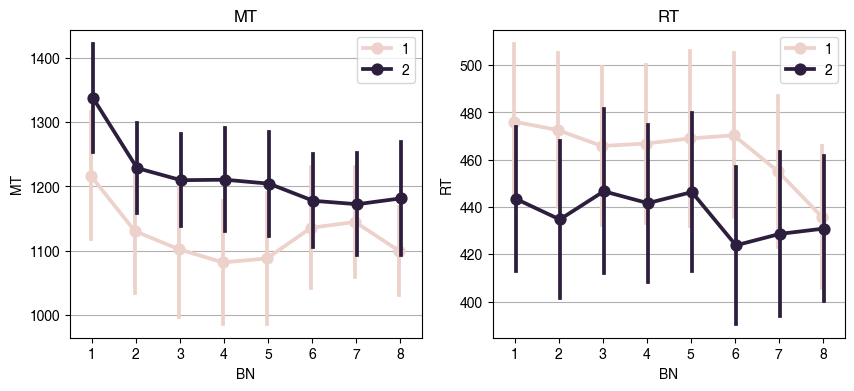

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, value in enumerate(['MT','RT']):
    print(value)
    ax = axs[ii]
    g = sns.pointplot(
        data=dh,
        x='BN', y=value, hue='sess',
        estimator='mean',
        errorbar='se', dodge=True,
        ax=ax
    )
    g.set_title(value)
    g.legend()
    g.grid(axis='y')

    # for sess in ['S','R']:
    #     tmp = dh[(dh.sess==sess)].set_index('subj', drop=False)
    #     a = tmp[tmp.BN==1][value].astype(float)
    #     b = tmp[tmp.BN==2][value].astype(float)
    #     res = scipy.stats.ttest_rel(a=a, b=b, alternative='two-sided')
    #     print(sess, 't(%d)=%.4f (%s)'%(res.df, res.statistic, sstat.convert_pval_to_star(res.pvalue)))

---
---

In [11]:
def get_df_groupby(df=dg, by=['sess','subj','cue','cond','x'], successed=True, estimate='mean'):
    if successed:
        dg = df[df.isError==0]
    else:
        dg = df
        
    if estimate=='mean':
        dg_groupby = dg.groupby(by)[['isError','MT','RT']].mean().reset_index()
    elif estimate=='median':
        dg_groupby = dg.groupby(by)[['isError','MT','RT']].median().reset_index()
    
    return dg_groupby

In [14]:
dg_groupby = get_df_groupby(df=dg, by=['subj','cue','cond'], successed=True, estimate='mean')
dg_groupby

,subj,cue,cond,isError,MT,RT
0,01,L,Between No-Rep,0.0,1654.947368,387.660819
1,01,L,Between Rep,0.0,1624.172414,430.586207
2,01,L,Within No-Rep,0.0,1652.642857,398.535714
3,01,L,Within Rep,0.0,1604.838710,399.064516
4,01,S,Between No-Rep,0.0,1628.552941,379.047059
...,...,...,...,...,...,...
91,14,L,Within Rep,0.0,995.803279,369.409836
92,14,S,Between No-Rep,0.0,987.618497,340.427746
93,14,S,Between Rep,0.0,983.866667,317.733333
94,14,S,Within No-Rep,0.0,989.144444,335.800000


In [49]:
hue_order = ['Within Rep','Within No-Rep','Between Rep','Between No-Rep']
order = ['L','S']
palette = ['#191970','#89CFF0','#800020','#F08080']
# palette = ['#191970','#800020']

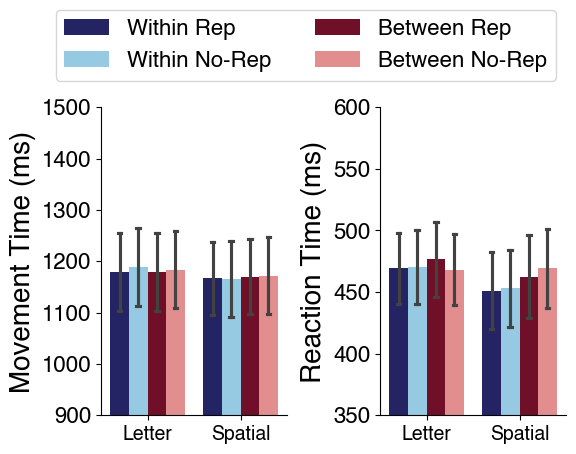

In [65]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

for ii, feature in enumerate(['MT','RT']):
    ax = axs[ii]
    g = sns.barplot(
        data=dg_groupby,
        x='cue', order=order,
        y=feature, estimator='mean',
        hue='cond', hue_order=hue_order,
        errorbar='se', capsize=0.15, dodge=True,
        palette=palette,
        ax=ax
    )
    # g = sns.swarmplot(
    #     data=dg_groupby,
    #     x='x', order=order,
    #     y=feature,
    #     hue='cond', hue_order=hue_order, dodge=True,
    #     edgecolor='black',
    #     palette=['#6A6AB8','#B3E4F9','#FFFFFF','#C08090','#F5A6A6'],
    #     ax=ax
    # )
    handles, labels = ax.get_legend_handles_labels()
    g.legend().remove()
    
    # g.grid(axis='y')
    if ii == 0:
        ylabel = 'Movement Time (ms)'
        g.set_ylim(900,1500)
        g.legend(
            handles[:4], labels[:4],
            loc='lower center', bbox_to_anchor=(1.1, 1.05),
            ncol=2, fontsize=16
        )
    elif ii == 1:
        ylabel = 'Reaction Time (ms)'
        g.set_ylim(350,600)

    g.set_xlabel('')
    # xticks = g.get_xticks()
    g.set_xticks([0,1])
    g.set_xticklabels(['Letter','Spatial'], fontsize=14)
    g.set_xlabel('', fontsize=16)
    yticks = g.get_yticks().astype(int)
    g.set_ylabel(ylabel,fontsize=20)
    g.set_yticks(yticks)
    g.set_yticklabels(yticks, fontsize=16)
    # g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
    # g.set_title('session %s'%sess,fontsize=16)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

plt.subplots_adjust(wspace=0.5)
# fig.tight_layout()

## ANOVA

In [51]:
for value in ['MT','RT']:
    print(value)
    aov = AnovaRM(
        data=dg_groupby,
        depvar=value,
        subject='subj',
        within=['cue','cond']
    ).fit()
    print(aov)

MT
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
cue      17.0699 1.0000 11.0000 0.0017
cond      0.3311 3.0000 33.0000 0.8029
cue:cond  0.8452 3.0000 33.0000 0.4790

RT
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
cue       4.9538 1.0000 11.0000 0.0479
cond      3.1610 3.0000 33.0000 0.0374
cue:cond  3.3579 3.0000 33.0000 0.0304



## paired t-test (Letter vs. Spatial)

#### i) Comparing different cues

In [52]:
df_groupby = get_df_groupby(df=dg, by=['subj','cue'], successed=True, estimate='mean')
df_groupby

,subj,cue,isError,MT,RT
0,01,L,0.0,1643.446623,398.605664
1,01,S,0.0,1607.331849,362.770601
2,02,L,0.0,1146.509395,378.141962
3,02,S,0.0,1113.703390,360.326271
4,03,L,0.0,1135.376344,415.569892
5,03,S,0.0,1127.397895,439.141053
6,05,L,0.0,1206.680672,426.352941
7,05,S,0.0,1208.525424,427.258475
8,06,L,0.0,1187.530655,708.646934
9,06,S,0.0,1178.473573,702.837209


MT: t(11)=4.9442 (***p=2.198e-04)
RT: t(11)=1.7852 (nsp=5.090e-02)


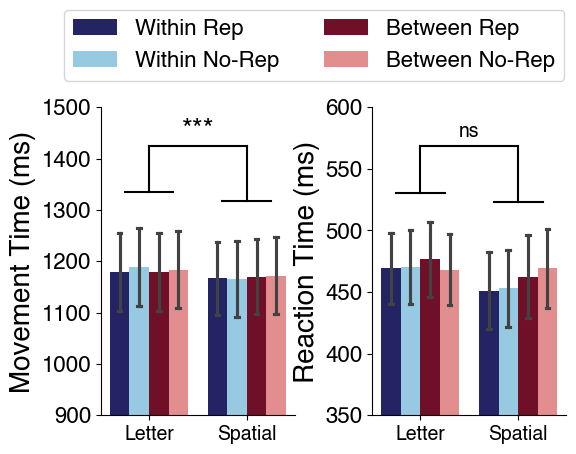

In [66]:
color = 'black'
for ii, value in enumerate(['MT','RT']):
    ax = axs[ii]
    ## t-test
    a = df_groupby[df_groupby.cue=='L'][value].astype(float)
    b = df_groupby[df_groupby.cue=='S'][value].astype(float)
    res = scipy.stats.ttest_rel(a,b,alternative='greater')
    tval = res.statistic
    pval = res.pvalue
    print('%s: t(%d)=%.4f (%sp=%.3e)'%(value, res.df, tval, sstat.convert_pval_to_star(pval), pval))
    if pval<0.05:
        fontsize = 20
    else:
        fontsize = 14
    
    ylim = np.array(ax.get_ylim())
    ydiff = np.diff(ylim)[0]
    ymean = ylim.mean()
    dy = ydiff * 0.05
    # ax.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
    
    x1 = 0
    y1 = a.mean() + a.sem() + dy*2.5
    ax.plot([x1-0.25,x1+0.25],[y1,y1],linestyle='-',color=color)
    x2 = 1
    y2 = b.mean() + b.sem() + dy*2.5
    ax.plot([x2-0.25,x2+0.25],[y2,y2],linestyle='-',color=color)
    yU = max(y1,y2) + dy*3
    ax.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    ax.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    ax.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    ax.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=fontsize, color=color,
        ha='center', va='center'
    )
fig.subplots_adjust(wspace=0.4)
fig

In [18]:
# fig.savefig(
#     join('/mnt/f/SeqSpatialSupp_fMRI/behav.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

## paired t-test (Sess-1 vs. Sess-2)

#### ii) Differences across session

In [18]:
df_groupby = get_df_groupby(df=dg, by=['subj','sess'], successed=False, estimate='mean')
df_groupby

,subj,sess,isError,MT,RT
0,01,1,0.060417,1783.070833,411.954167
1,01,2,0.047917,1463.066667,350.837500
2,02,1,0.008333,1030.395833,374.012500
3,02,2,0.010417,1235.854167,365.937500
4,03,1,0.022917,1042.945833,441.758333
5,03,2,0.018750,1223.720833,416.445833
6,05,1,0.020833,1094.920833,425.166667
7,05,2,0.004167,1327.291667,428.112500
8,06,1,0.027083,1050.216667,735.045833
9,06,2,0.002083,1312.808333,678.241667


t(11)=2.5109 (*p=1.447e-02)


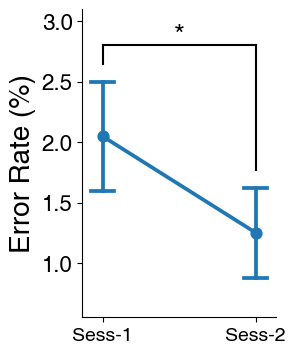

In [19]:
fig, ax = plt.subplots(figsize=(2.5,4))
g = sns.pointplot(
    data = df_groupby,
    x = 'sess', order=[1,2],
    y='isError',
    errorbar='se', capsize=0.15,
    ax=ax
)
# g.grid(axis='y')
g.set_xlabel('')
g.set_xticks([0,1])
g.set_xticklabels(['Sess-1','Sess-2'], fontsize=14)
g.set_ylabel('Error Rate (%)', fontsize=20)
# yticks = g.get_yticks()
yticks = np.arange(0.005,0.035,0.005)
g.set_yticks(yticks)
g.set_yticklabels(['%.01f'%(y*100) for y in yticks], fontsize=16)
g.set_ylim(0.01,0.025)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

## t-test
a = df_groupby[df_groupby.sess==1]['isError'].astype(float)
b = df_groupby[df_groupby.sess==2]['isError'].astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%sp=%.3e)'%(res.df, tval, sstat.convert_pval_to_star(pval), pval))

ylim = np.array(g.get_ylim())
ydiff = np.diff(ylim)[0]
ymean = ylim.mean()
dy = ydiff * 0.05
g.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
if pval < 0.05:
    x1 = 0
    x2 = 1
    y1 = a.mean() + a.sem() + 2*dy
    y2 = b.mean() + b.sem() + 2*dy
    yU = max(y1,y2) + dy*2
    color = 'black'
    g.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    g.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    g.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    g.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=20, color=color,
        ha='center', va='center'
    )

In [21]:
# fig.savefig(
#     join('/mnt/f/SeqSpatialSupp_fMRI/error.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

#### iii) Repetition advantage

In [33]:
dg['cond_'] = ['Between' if 'Between' in cond else('Within' if 'Within' in cond else 'invalid') for cond in dg.cond]
dg_groupby = dg[dg.isError==0].groupby(['sess','subj','cond_'])[['isError','MT','RT']].mean().reset_index()

In [34]:
dg_groupby

,sess,subj,cond_,isError,MT,RT
0,1,01,Between,0.0,1810.775862,417.293103
1,1,01,Within,0.0,1782.849315,405.360731
2,1,02,Between,0.0,1029.805085,375.500000
3,1,02,Within,0.0,1028.325000,373.091667
4,1,03,Between,0.0,1033.327586,448.844828
5,1,03,Within,0.0,1039.130802,429.814346
6,1,05,Between,0.0,1094.903766,432.410042
7,1,05,Within,0.0,1083.696970,418.337662
8,1,06,Between,0.0,1041.626087,737.043478
9,1,06,Within,0.0,1052.312236,732.616034


In [40]:
tmp = dg_groupby[dg_groupby.sess==1]
a = tmp[tmp.cond_=='Between'].RT.astype(float)
b = tmp[tmp.cond_=='Within'].RT.astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%sp=%.3e)'%(res.df, tval, sstat.convert_pval_to_star(pval), pval))

t(11)=2.9106 (**p=7.086e-03)


---
---

### 어떤 Seq가 어려웠나?

In [89]:
sess = 'S'

In [90]:
df = pd.DataFrame()
for sn in list_sn:
    subj = sess+sn
    fname = join(dir_behav,'sub-%s/ssh__%s.dat'%(subj,subj))
    df_tmp = pd.read_csv(fname, delimiter='\t')
    df_tmp = df_tmp[['BN','TN','seqType','cueP','MT','RT','points','isError']]
    
    ## 각 run의 가장 마지막 trial은 제외
    # df = df[df.iti<2000]

    ## 9번째 run (long ITI)은 제거
    df_tmp = df_tmp[df_tmp.BN < 9]

    ## 성공적으로 수행한 trial들만 고려
    # df_tmp = df_tmp[df_tmp.points == 1]
    df_tmp = df_tmp[df_tmp.isError == 0]

    df_tmp.seqType = ['Letter' if i==0 else 'Spatial' for i in df_tmp.seqType]
    df_tmp.cueP = df_tmp.cueP.astype('str')

    df_tmp['subj'] = subj
    # df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp.seqType,df_tmp.sess)]

    df = pd.concat([df,df_tmp])

df.rename(columns={'seqType':'cue', 'cueP':'seq'}, inplace=True)
df['cue'] = df.cue.replace({'Letter':'L', 'Spatial':'S'})
df

,BN,TN,cue,seq,MT,RT,points,isError,subj
0,1,1,S,35124,1680,566,1,0,S01
1,1,2,S,14523,1720,382,1,0,S01
2,1,3,L,14523,2056,438,1,0,S01
3,1,4,L,35124,1528,478,1,0,S01
4,1,5,S,32451,1308,408,1,0,S01
...,...,...,...,...,...,...,...,...,...
539,8,64,S,32451,796,436,1,0,S14
540,8,65,L,32451,790,404,1,0,S14
541,8,66,S,32451,832,246,1,0,S14
542,8,67,L,14523,816,400,1,0,S14


In [91]:
df_groupby = df.groupby(['subj','cue','seq'])[['MT','RT']].mean().reset_index()
df_groupby

,subj,cue,seq,MT,RT
0,S01,L,13254,1740.716418,435.940299
1,S01,L,14523,1927.096774,410.451613
2,S01,L,32451,1756.062500,438.656250
3,S01,L,35124,1728.212121,440.303030
4,S01,S,13254,1668.707692,407.138462
...,...,...,...,...,...
91,S14,L,35124,938.656716,368.358209
92,S14,S,13254,937.384615,349.384615
93,S14,S,14523,958.477612,337.910448
94,S14,S,32451,974.176471,320.911765


In [92]:
list_seq = ['32451','35124','13254','14523']

MT
32451
t(11)=2.1735, nsp=0.0525
35124
t(11)=0.1990, nsp=0.8459
13254
t(11)=1.6369, nsp=0.1299
14523
t(11)=0.4050, nsp=0.6932
RT
32451
t(11)=5.7743, ***p=0.0001
35124
t(11)=3.3537, **p=0.0064
13254
t(11)=0.9114, nsp=0.3816
14523
t(11)=0.5741, nsp=0.5774


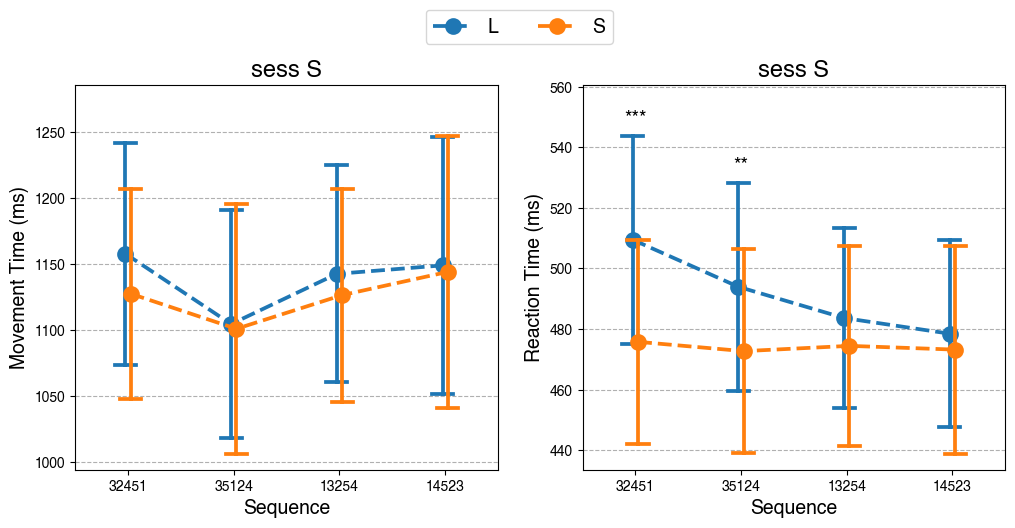

In [93]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

hue = 'cue'
# hue = 'sess'
for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.pointplot(
        data=df_groupby,
        x='seq', order=list_seq, y=feature, hue=hue,
        linestyles='--', markers=['o','o'], markersize=10,
        errorbar='se', capsize=0.2, dodge=True,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    if ii==0:
        g.legend(loc='center', bbox_to_anchor=(1.05, 1.15), ncol=2, fontsize=14)
    else:
        g.legend().remove()
    g.set_xlabel('Sequence', fontsize=14)
    ylabel = 'Movement Time (ms)' if feature=='MT' else 'Reaction Time (ms)'
    g.set_ylabel(ylabel, fontsize=14)
    g.set_title('sess %s'%sess, fontsize=17)
    ya, yb = g.get_ylim()
    dy = (yb-ya) * 0.05

    ## t-test
    for ss, seq in enumerate(list_seq):
        print(seq)
        a = df_groupby[(df_groupby.cue=='L')&(df_groupby.seq==seq)][feature].astype(float)
        b = df_groupby[(df_groupby.cue=='S')&(df_groupby.seq==seq)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,sstat.convert_pval_to_star(pval),pval))
        
        if pval < 0.05:
            x = ss # + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()
            y2 = b.mean()+b.sem()
            y = max(y1,y2) + dy
            
            g.text(
                x, y,
                sstat.convert_pval_to_star(pval), fontsize=14, color='black',
                ha='center', va='center',
            )
    g.set_ylim(ya,yb+dy*2)

-> Spatial Cue의 경우 직관적이므로, 반응시간(RT)과 입력시간(MT) 모두 단축되었으며, sequence에 관계없이 비슷한 시간들을 나타낸다.

-> 첫 손가락이 '3'인 경우 입력 속도가 느림 (RT$\uparrow$)

---
---

In [30]:
# fig.savefig(
#     join(dir_work,'results/fig.behav.Rep.barplot.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

### 왜 session R에서 MT가 더 높은가?
- 단순히 더 정확히 하기 위해서 느려진 것이 아닌가?

In [18]:
palette = ['#4a83d1','#d1984a']

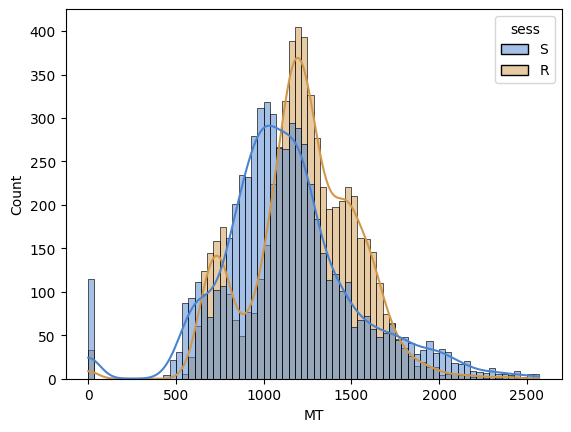

In [19]:
g = sns.histplot(
    data=dg,
    x='MT',
    hue='sess', palette=palette, kde=True,
    alpha=0.5
)
# g.legend()

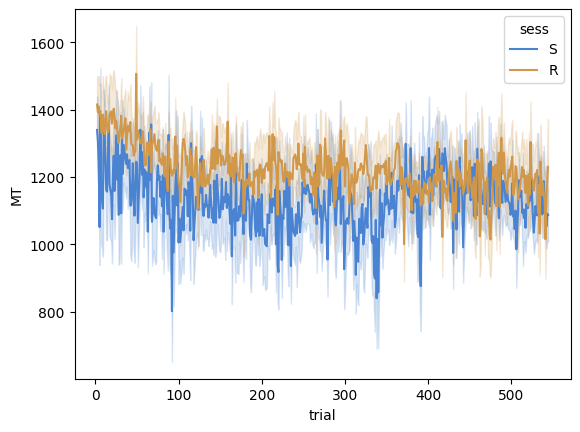

In [20]:
g = sns.lineplot(
    data=dg,
    x='trial', y='MT',
    hue='sess', palette=palette,
    errorbar='se', err_style='band'
)

-> 실험 초반에 느리게 함. 정확성을 위해서가 맞는 듯.

---